# Import

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from six import BytesIO
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from sklearn.utils import check_random_state
import tensorflow_hub as hub
from six.moves.urllib.request import urlopen

import glob
import os
from itertools import accumulate
from sklearn.linear_model._ransac import _dynamic_max_trials


Instructions for updating:
non-resource variables are not supported in the long term


# GDrive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/MyDrive/Image_retrival

/content/gdrive/MyDrive/Image_retrival


# Pre Processing Image

In [4]:
def image_input_fn(image_files):
    filename_queue = tf.train.string_input_producer(
        image_files, shuffle=False)
    # print(filename_queue)
    reader = tf.WholeFileReader()
    _, value = reader.read(filename_queue)
    image_tf = tf.image.decode_jpeg(value, channels=3)
    return tf.image.convert_image_dtype(image_tf, tf.float32)

In [5]:

"""## Resize all database images"""

def resize_image(src_image, destfile, new_width=256, new_height=256):
    # pil_image = Image.open(srcfile)
    pil_image = ImageOps.fit(src_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert('RGB')
    pil_image_rgb.save(destfile)
    return destfile


def resize_images_folder(srcfolder, destfolder, new_width=256, new_height=256):
    os.makedirs(destfolder,exist_ok=True)
    list_image = os.listdir(srcfolder)  #srcfolder = oxbuild_image #destfolder = database
    for srcfile in list_image:
        srcfile_ = os.path.join(srcfolder,srcfile) # srcfile_ = oxbuild_image/...jpg
        destfile = os.path.join(destfolder,srcfile)
        src_image = Image.open(srcfile_)
        resize_image(src_image, destfile, new_width, new_height)
        
    return destfolder


def get_resized_db_image_paths(destfolder='resized_image'):
    return sorted(list(glob.iglob(os.path.join(destfolder, '*.jpg'))))

In [6]:
#resize_images_folder('oxbuild_images','resized_image')
db_images = get_resized_db_image_paths()

# Extract feature

In [7]:
"""## Extract feature all database images folder"""
tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.FATAL)

m = hub.Module('https://tfhub.dev/google/delf/1')
image_placeholder = tf.placeholder(
            tf.float32, shape=(None, None, 3), name='input_image')

module_inputs = {
        'image': image_placeholder,
        'score_threshold': 100.0,
        'image_scales': [0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0],
        'max_feature_num': 1000,
    }
module_outputs = m(module_inputs, as_dict=True)    
image_tf = image_input_fn(db_images)

with tf.train.MonitoredSession() as sess:
  results_dict = {}  # Stores the locations and their descriptors for each image
  for image_path in db_images:
    image = sess.run(image_tf)
    #print('Extracting locations and descriptors from %s' % image_path)
    results_dict[image_path] = sess.run(
        [module_outputs['locations'], module_outputs['descriptors']],
        feed_dict={image_placeholder: image})

In [8]:
locations_agg = np.concatenate([results_dict[img][0] for img in db_images])
descriptors_agg = np.concatenate([results_dict[img][1] for img in db_images])
accumulated_indexes_boundaries = list(accumulate([results_dict[img][0].shape[0] for img in db_images]))

In [9]:
"""## Extract feature query images """
def compute_locations_and_descriptors(image_path):
    tf.reset_default_graph()
    tf.logging.set_verbosity(tf.logging.FATAL)

    m = hub.Module('https://tfhub.dev/google/delf/1')

    # The module operates on a single image at a time, so define a placeholder to
    # feed an arbitrary image in.
    image_placeholder = tf.placeholder(
        tf.float32, shape=(None, None, 3), name='input_image')

    module_inputs = {
        'image': image_placeholder,
        'score_threshold': 100.0,
        'image_scales': [0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0],
        'max_feature_num': 1000,
    }

    module_outputs = m(module_inputs, as_dict=True)

    image_tf = image_input_fn([image_path])

    with tf.train.MonitoredSession() as sess:
        image = sess.run(image_tf)
        print('Extracting locations and descriptors from %s' % image_path)
        return sess.run(
            [module_outputs['locations'], module_outputs['descriptors']],
            feed_dict={image_placeholder: image})

# KD Tree

In [10]:
d_tree = cKDTree(descriptors_agg) # build the KD tree

# Query Image

## Processing query image

In [11]:
# image_path = 'query_image/worcester_000184.jpg'
# image_query = Image.open(image_path)
def process_query_image(image_query,image_path):
  resized_image = resize_image(image_query,image_path)
  query_image_locations, query_image_descriptors = compute_locations_and_descriptors(resized_image)
  return resized_image,query_image_locations, query_image_descriptors 


## Query Kd Tree to find K nearest neighbor

In [12]:
def KDtree(query_image_descriptors,K):
  distance_threshold = 0.8
  # K nearest neighbors
  distances, indices = d_tree.query(
    query_image_descriptors, distance_upper_bound=distance_threshold, k = K, n_jobs=-1)

  # Find the list of unique accumulated/aggregated indexes
  unique_indices = np.array(list(set(indices.flatten())))

  unique_indices.sort()
  if unique_indices[-1] == descriptors_agg.shape[0]:
    unique_indices = unique_indices[:-1]
  return unique_indices,indices

## Get list of database image

In [13]:
def get_index_image(unique_indices):
  unique_image_indexes = np.array(
        list(set([np.argmax([np.array(accumulated_indexes_boundaries)>index]) 
              for index in unique_indices])))
  return unique_image_indexes

In [14]:
def image_index_2_accumulated_indexes(index, accumulated_indexes_boundaries):
    '''
    Image index to accumulated/aggregated locations/descriptors pair indexes.
    '''
    if index > len(accumulated_indexes_boundaries) - 1:
        return None
    accumulated_index_start = None
    accumulated_index_end = None
    if index == 0:
        accumulated_index_start = 0
        accumulated_index_end = accumulated_indexes_boundaries[index]
    else:
        accumulated_index_start = accumulated_indexes_boundaries[index-1]
        accumulated_index_end = accumulated_indexes_boundaries[index]
    return np.arange(accumulated_index_start,accumulated_index_end)

In [15]:
def get_locations_2_use(image_db_index, k_nearest_indices, accumulated_indexes_boundaries, query_image_locations):
    image_accumulated_indexes = image_index_2_accumulated_indexes(image_db_index, accumulated_indexes_boundaries)
    locations_2_use_query = []
    locations_2_use_db = []
    for i, row in enumerate(k_nearest_indices):
        for acc_index in row:
            if acc_index in image_accumulated_indexes:
                locations_2_use_query.append(query_image_locations[i])
                locations_2_use_db.append(locations_agg[acc_index])
                break
    return np.array(locations_2_use_query), np.array(locations_2_use_db)


## Perform visualize choose the best

In [16]:
def ransac(data, model_class, min_samples, residual_threshold,
           is_data_valid=None, is_model_valid=None,
           max_trials=100, stop_sample_num=np.inf, stop_residuals_sum=0,
           stop_probability=1, random_state=None, initial_inliers=None):
    best_model = None
    best_inlier_num = 0
    best_inlier_residuals_sum = np.inf
    best_inliers = None

    random_state = check_random_state(random_state)

    # in case data is not pair of input and output, male it like it
    if not isinstance(data, (tuple, list)):
        data = (data, )
    num_samples = len(data[0])
    #print('number: ',num_samples)
    if not (0 < min_samples < num_samples):
        return None, None

    if residual_threshold < 0:
        raise ValueError("`residual_threshold` must be greater than zero")

    if max_trials < 0:
        raise ValueError("`max_trials` must be greater than zero")

    if not (0 <= stop_probability <= 1):
        raise ValueError("`stop_probability` must be in range [0, 1]")

    if initial_inliers is not None and len(initial_inliers) != num_samples:
        raise ValueError("RANSAC received a vector of initial inliers (length %i)"
                         " that didn't match the number of samples (%i)."
                         " The vector of initial inliers should have the same length"
                         " as the number of samples and contain only True (this sample"
                         " is an initial inlier) and False (this one isn't) values."
                          % (len(initial_inliers), num_samples))

    # for the first run use initial guess of inliers
    spl_idxs = (initial_inliers if initial_inliers is not None else random_state.choice(num_samples, min_samples, replace=False))

    for num_trials in range(max_trials):
        # do sample selection according data pairs
        samples = [d[spl_idxs] for d in data]
        # for next iteration choose random sample set and be sure that no samples repeat
        spl_idxs = random_state.choice(num_samples, min_samples, replace=False)

        # optional check if random sample set is valid
        if is_data_valid is not None and not is_data_valid(*samples):
            continue

        # estimate model for current random sample set
        sample_model = model_class()

        success = sample_model.estimate(*samples)
        # backwards compatibility
        if success is not None and not success:
            continue

        # optional check if estimated model is valid
        if is_model_valid is not None and not is_model_valid(sample_model, *samples):
            continue

        sample_model_residuals = np.abs(sample_model.residuals(*data))
        # consensus set / inliers
        sample_model_inliers = sample_model_residuals < residual_threshold
        sample_model_residuals_sum = np.sum(sample_model_residuals ** 2)

        # choose as new best model if number of inliers is maximal
        sample_inlier_num = np.sum(sample_model_inliers)
        if (
            # more inliers
            sample_inlier_num > best_inlier_num
            # same number of inliers but less "error" in terms of residuals
            or (sample_inlier_num == best_inlier_num
                and sample_model_residuals_sum < best_inlier_residuals_sum)
        ):
            best_model = sample_model
            best_inlier_num = sample_inlier_num
            best_inlier_residuals_sum = sample_model_residuals_sum
            best_inliers = sample_model_inliers
            dynamic_max_trials = _dynamic_max_trials(best_inlier_num,
                                                     num_samples,
                                                     min_samples,
                                                     stop_probability)
            if (best_inlier_num >= stop_sample_num
                or best_inlier_residuals_sum <= stop_residuals_sum
                or num_trials >= dynamic_max_trials):
                break

    # estimate final model using all inliers
    if best_inliers is not None and any(best_inliers):
        # select inliers for each data array
        data_inliers = [d[best_inliers] for d in data]
        best_model.estimate(*data_inliers)
    else:
        best_model = None
        best_inliers = None

    return best_model, best_inliers


In [17]:
def visualize(img_1,img_2,inliers,locations_2_use_db,locations_2_use_query):
    _, ax = plt.subplots()
    inlier_idxs = np.nonzero(inliers)[0]
    plot_matches(
        ax,
        img_1,
        img_2,
        locations_2_use_db,
        locations_2_use_query,
        np.column_stack((inlier_idxs, inlier_idxs)),
        matches_color='b')
    ax.axis('off')
    ax.set_title('DELF correspondences')
    plt.show()

In [18]:
def final_process(resized_image,unique_image_indexes,indices,query_image_locations,flag):
      inliers_counts = []
      img_1 = mpimg.imread(resized_image)
      for index in unique_image_indexes:
          locations_2_use_query, locations_2_use_db = get_locations_2_use(index, indices, accumulated_indexes_boundaries, query_image_locations)
          # Perform geometric verification using RANSAC.
          _, inliers = ransac(
                (locations_2_use_db, locations_2_use_query), # source and destination coordinates
                AffineTransform,
                min_samples=5,
                residual_threshold=20,
                max_trials=50)
            # If no inlier is found for a database candidate image, we continue on to the next one.
          if inliers is None or len(inliers) == 0:
                continue
            # the number of inliers as the score for retrieved images.
          img_2 = mpimg.imread(db_images[index]) 
          if flag == 1:
            visualize(img_1,img_2,inliers,locations_2_use_db,locations_2_use_query)  
          inliers_counts.append({"index": index, "inliers": sum(inliers)})
      # top match result
      top_match = sorted(inliers_counts, key=lambda k: k['inliers'], reverse=True)
      return top_match


# Test

In [19]:
def text(image,name):
  count = 0 
  resized_image, query_image_locations, query_image_descriptors = process_query_image(image,'query_image/1.jpg')

  unique_indices,indices = KDtree(query_image_descriptors,10)
  unique_image_indexes = get_index_image(unique_indices)

  res_top = final_process(resized_image,unique_image_indexes,indices,query_image_locations,1)
  for item in res_top:
    print(db_images[item['index']])
    if (db_images[item['index']][14:-11] == name):
      count+=1
  print(count, len(res_top))
  return count/len(res_top)


Extracting locations and descriptors from query_image/1.jpg


<ipython-input-12-d8a7ad9d0c00>:4: DeprecationWarning: The n_jobs argument has been renamed "workers". The old name "n_jobs" will stop working in SciPy 1.8.0.
  distances, indices = d_tree.query(


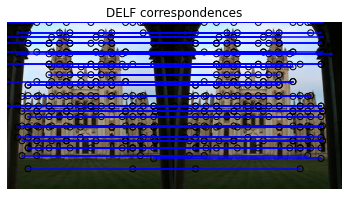

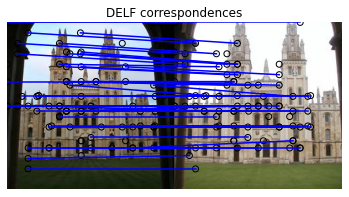

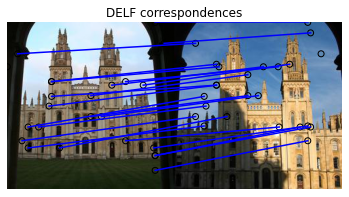

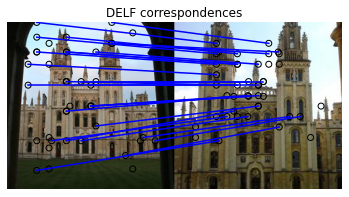

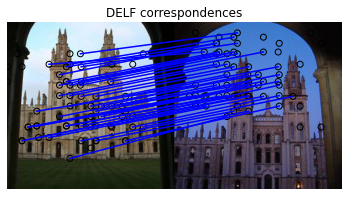

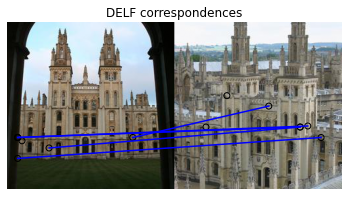

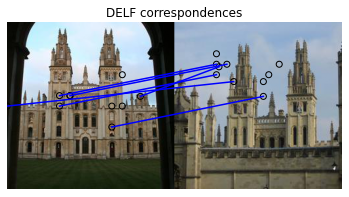

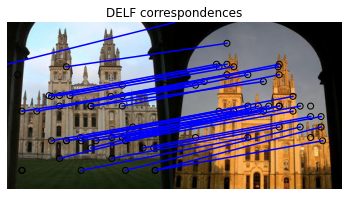

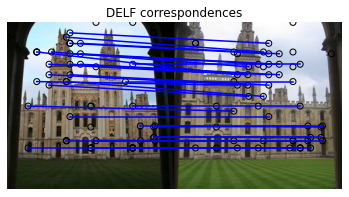

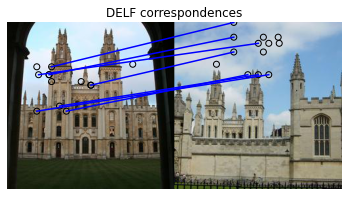

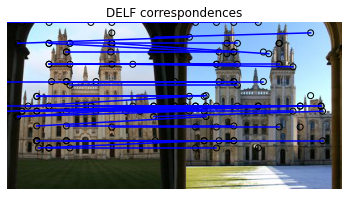

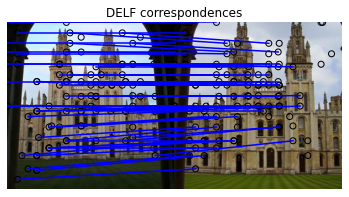

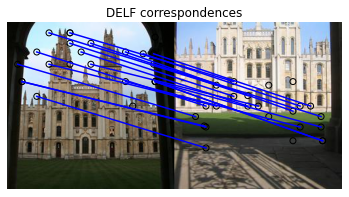

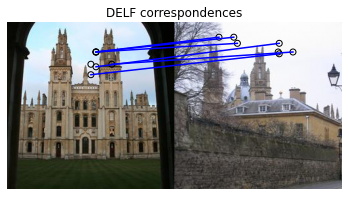

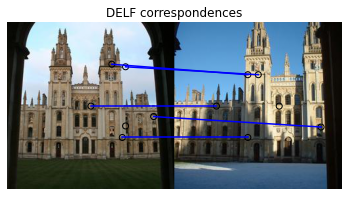

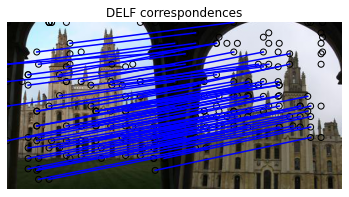

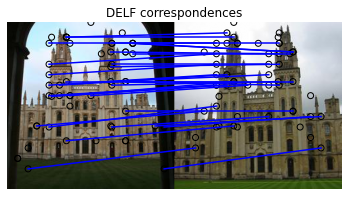

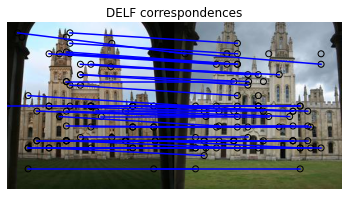

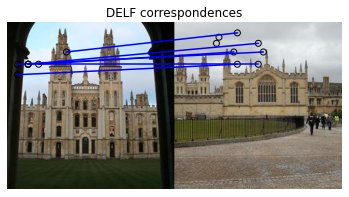

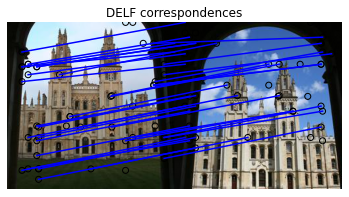

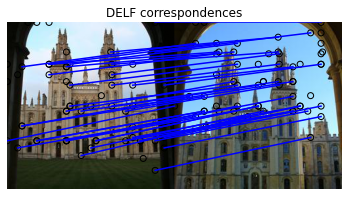

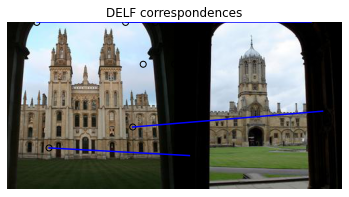

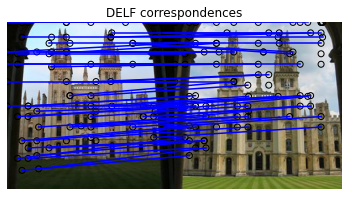

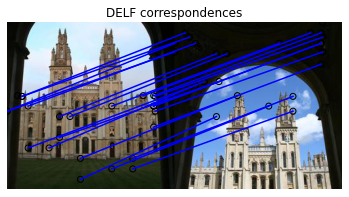

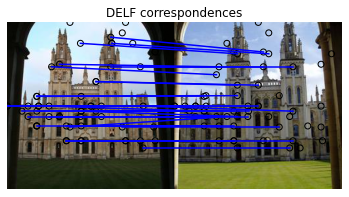

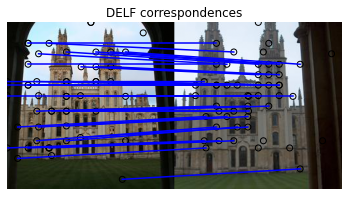

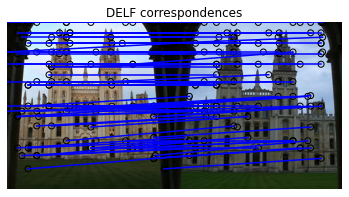

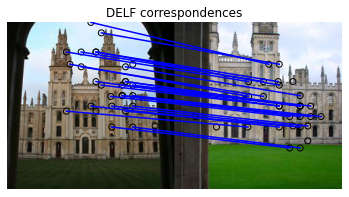

resized_image/all_souls_000002.jpg
resized_image/oxford_002503.jpg
resized_image/all_souls_000091.jpg
resized_image/all_souls_000140.jpg
resized_image/oxford_002985.jpg
resized_image/all_souls_000006.jpg
resized_image/all_souls_000150.jpg
resized_image/all_souls_000068.jpg
resized_image/all_souls_000040.jpg
resized_image/all_souls_000209.jpg
resized_image/oxford_002358.jpg
resized_image/oxford_002338.jpg
resized_image/oxford_003056.jpg
resized_image/oxford_000478.jpg
resized_image/all_souls_000055.jpg
resized_image/all_souls_000146.jpg
resized_image/all_souls_000026.jpg
resized_image/oxford_000130.jpg
resized_image/all_souls_000015.jpg
resized_image/oxford_003410.jpg
resized_image/all_souls_000103.jpg
resized_image/all_souls_000064.jpg
resized_image/radcliffe_camera_000293.jpg
resized_image/all_souls_000107.jpg
resized_image/all_souls_000152.jpg
resized_image/all_souls_000041.jpg
resized_image/all_souls_000126.jpg
resized_image/christ_church_001020.jpg
18 28
Precision 0.642857142857142

In [20]:
image_query = Image.open('/content/gdrive/MyDrive/Image_retrival/query_image/all_souls_000002.jpg')
precision = text(image_query,'all_souls')
print('Precision', precision)

# Demo

In [19]:
!pip install flask==0.12.2
!pip install pyngrok==4.1.1
!pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
from flask_ngrok import run_with_ngrok
from flask import Flask, request, render_template,redirect, url_for, jsonify
import pickle
import numpy as np
from time import sleep
from flask import send_file
import os


In [21]:
!ngrok authtoken "2LvAQMwzaIsZST25LjTfHQDYXaQ_Uf8jkYqC9nHpFR7aQb2o" #Without "" marks 

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [22]:
import shutil
def copy_file(src,dst):
  shutil.copyfile(src, dst)

In [25]:
#!git clone https://github.com/fengyuanchen/cropperjs

In [35]:
from numpy.core.numeric import indices
app = Flask(__name__,template_folder='templates',static_folder='static')
run_with_ngrok(app)


@app.route('/')
def index():
    print('ok')  
    return render_template('index.html')
@app.route('/get_image',methods=['POST'])
def get_image():
  print('1.ok')
  print(request)
  image = request.files["image"]
  try:
    image_2 = request.files["image_2"]
  except:
    pass
  image = Image.open(image.stream)
  print(image)
  _,query_image_locations, query_image_descriptors = process_query_image(image,'query_image/1.jpg')

  unique_indices,indices = KDtree(query_image_descriptors,10)
  unique_image_indexes = get_index_image(unique_indices)

  res_top = final_process(_,unique_image_indexes,indices,query_image_locations,0)

  image_names =[]
  print(res_top)
  for id,i in enumerate(res_top):
      des = 'static/'+str(id)+'.jpg'
      copy_file(db_images[i['index']],des)
      image_names.append(des)
  print(image_names)
  return render_template('search.html',image_names=image_names)
# @app.route('/get_image',methods=['POST'])
# def get_image():
#   #input = request.form.get("Address")
#   return render_template("index.html")

app.run()

INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://1e8a-34-91-254-96.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [20/Feb/2023 14:25:29] "GET / HTTP/1.1" 200 -


ok


INFO:werkzeug:127.0.0.1 - - [20/Feb/2023 14:25:30] "GET /static/cropperjs/dist/cropper.min.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Feb/2023 14:25:30] "GET /static/cropperjs/dist/cropper.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Feb/2023 14:25:30] "GET /static/js/script.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Feb/2023 14:25:32] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [20/Feb/2023 14:25:43] "GET / HTTP/1.1" 200 -


ok
1.ok
<Request 'http://1e8a-34-91-254-96.ngrok.io/get_image' [POST]>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=157x141 at 0x7FDFBE3B4610>
Extracting locations and descriptors from query_image/1.jpg


<ipython-input-12-d8a7ad9d0c00>:4: DeprecationWarning: The n_jobs argument has been renamed "workers". The old name "n_jobs" will stop working in SciPy 1.8.0.
  distances, indices = d_tree.query(
INFO:werkzeug:127.0.0.1 - - [20/Feb/2023 14:26:29] "POST /get_image HTTP/1.1" 200 -


[{'index': 5055, 'inliers': 25}, {'index': 3265, 'inliers': 7}, {'index': 3716, 'inliers': 7}, {'index': 796, 'inliers': 6}, {'index': 2891, 'inliers': 6}, {'index': 4956, 'inliers': 6}, {'index': 3094, 'inliers': 6}, {'index': 3340, 'inliers': 6}, {'index': 1490, 'inliers': 6}, {'index': 3674, 'inliers': 6}, {'index': 1704, 'inliers': 6}, {'index': 2063, 'inliers': 5}, {'index': 145, 'inliers': 5}, {'index': 2905, 'inliers': 5}, {'index': 1357, 'inliers': 5}, {'index': 4089, 'inliers': 5}, {'index': 4441, 'inliers': 4}, {'index': 3439, 'inliers': 4}, {'index': 3513, 'inliers': 4}, {'index': 332, 'inliers': 3}, {'index': 1123, 'inliers': 3}, {'index': 1305, 'inliers': 3}, {'index': 3774, 'inliers': 2}]
['static/0.jpg', 'static/1.jpg', 'static/2.jpg', 'static/3.jpg', 'static/4.jpg', 'static/5.jpg', 'static/6.jpg', 'static/7.jpg', 'static/8.jpg', 'static/9.jpg', 'static/10.jpg', 'static/11.jpg', 'static/12.jpg', 'static/13.jpg', 'static/14.jpg', 'static/15.jpg', 'static/16.jpg', 'static/